In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, log_loss

In [2]:
from medmnist import DermaMNIST, RetinaMNIST

In [3]:
import torch
import torchvision.transforms as tr
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [4]:
if torch.cuda.is_available():
    print('using the GPU')
    device = 'cuda'
else: 
    print('using the CPU')
    device='cpu'

using the GPU


In [5]:
def set_seed(seed_value):
    if seed_value is not None:
        np.random.seed(seed_value)  # cpu vars
        torch.manual_seed(seed_value)  # cpu  vars
        random.seed(seed_value)  # Python
        # torch.use_deterministic_algorithms(True)

        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed_value)
            torch.cuda.manual_seed_all(seed_value)
            torch.backends.cudnn.deterministic = True
set_seed(0)

### Data
In this hands-on session we will be playing with `medMNIST`, a collection of datasets similar to MNIST but with medical images. For the sake of quick training, we will be using skin and retinal images, as `RetinaMNIST` and `DermaMNIST` are the smallest datasets in `medMNIST`. The `dataset` variable next allows you to pick one of these.

In [6]:
dataset = 'DERMA'

In [7]:
# preprocessing - to-tensor and normalize using imagenet stats
transforms = tr.Compose([tr.ToTensor(), tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# datasets
if dataset == 'DERMA':
    train_dataset = DermaMNIST(split='train', transform=transforms, download=True)
    val_dataset   = DermaMNIST(split='val', transform=transforms, download=True)
    test_dataset  = DermaMNIST(split='test', transform=transforms, download=True)
elif dataset == 'RETINA':
    train_dataset = RetinaMNIST(split='train', transform=transforms, download=True)
    val_dataset   = RetinaMNIST(split='val', transform=transforms, download=True)
    test_dataset  = RetinaMNIST(split='test', transform=transforms, download=True)
else:
    print('please choose between dataset=\'DERMA\' or dataset=\'RETINA\'')

# dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset,   batch_size=256, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=256, shuffle=False)

Using downloaded and verified file: /home/u109509/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/u109509/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/u109509/.medmnist/dermamnist.npz


In [8]:
len(train_dataset), len(val_dataset), len(test_dataset)

(7007, 1003, 2005)

Let us have a look at the data, it cannot hurt.

In [9]:
np.unique(train_dataset.labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8),
 array([ 228,  359,  769,   80,  779, 4693,   99]))

In [10]:
N_CLASSES = len(np.unique(train_dataset.labels))

if dataset == 'DERMA':
    n_epochs_simple, n_epochs_overfit = 5, 20
    lr, ylim = 1e-4, 600
elif dataset == 'RETINA':
    n_epochs_simple, n_epochs_overfit = 3, 10
    lr, ylim = 1e-3, 70

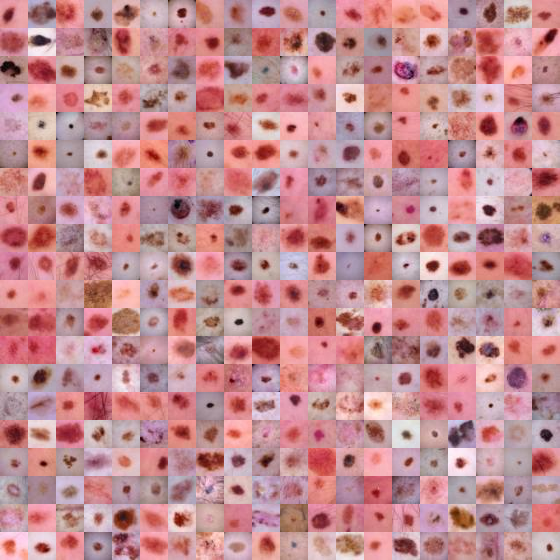

In [11]:
train_dataset.montage(length=20)

### Model Training
The next cell defines a standard training loop in pytorch:

In [12]:
def run_one_epoch(loader, model, criterion, optimizer=None):

    device='cuda' if next(model.parameters()).is_cuda else 'cpu'
    train = optimizer is not None  # if we are in training mode there will be an optimizer and train=True here

    if train: model.train()
    else: model.eval()
    probs_all, preds_all, labels_all = [], [], []
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        logits = model(inputs)
        loss = criterion(logits, labels)

        if train:  # only in training mode
            loss.backward()
            optimizer.step()

        probs = logits.softmax(dim=1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=1)
        labels = labels.cpu().numpy()

        probs_all.extend(probs)
        preds_all.extend(preds)
        labels_all.extend(labels)
            
    return np.stack(preds_all), np.stack(probs_all), np.stack(labels_all)

As usual, we will be needing a model, an optimizer, and a criterion. In this tutorial, we will be training a model for a few epochs (`simple_model`), and then another one for longer (`overfit_model`).

In [13]:
simple_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = simple_model.fc.in_features
simple_model.fc = torch.nn.Linear(num_ftrs, out_features=N_CLASSES)
simple_model.to(device);

optimizer = torch.optim.SGD(simple_model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

Let us train `simple_model` for a few epochs and then analyze predictions. We monitor AUC on the training and the validation set to detect overfitting.

In [14]:
for epoch in tqdm(range(n_epochs_simple)):
    _,  _, _ = run_one_epoch(train_loader, simple_model, criterion, optimizer)
    with torch.inference_mode():
        tr_preds, tr_probs, tr_labels = run_one_epoch(train_loader, simple_model, criterion)
        vl_preds_simple, vl_probs_simple, vl_labels = run_one_epoch(val_loader, simple_model, criterion)

        tr_auc = roc_auc_score(tr_labels, tr_probs, multi_class='ovr')
        vl_auc = roc_auc_score(vl_labels, vl_probs_simple, multi_class='ovr')
        print('Epoch {}, TR/VL AUC={:.2f}/{:.2f}'.format(epoch+1, 100*tr_auc, 100*vl_auc))

 20%|█████████████████████████████████▊                                                                                                                                       | 1/5 [00:05<00:21,  5.44s/it]

Epoch 1, TR/VL AUC=82.42/80.97


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 2/5 [00:09<00:13,  4.53s/it]

Epoch 2, TR/VL AUC=87.53/84.22


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3/5 [00:13<00:08,  4.22s/it]

Epoch 3, TR/VL AUC=90.03/86.74


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4/5 [00:17<00:04,  4.07s/it]

Epoch 4, TR/VL AUC=91.51/89.85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.17s/it]

Epoch 5, TR/VL AUC=92.44/90.89


A quick way of observing how confident is our model is to look at the maximum probability for each validation sample:

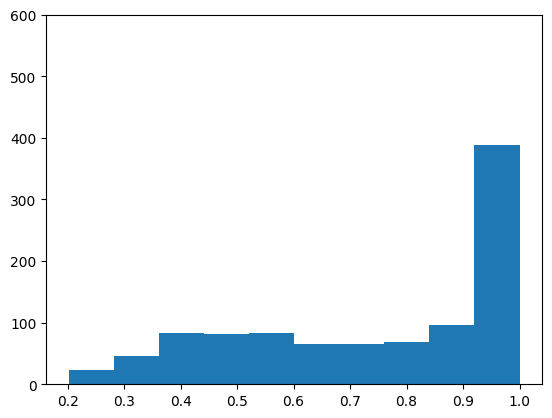

In [15]:
vl_confs_simple = vl_probs_simple.max(axis=1)
plt.hist(vl_confs_simple);
plt.ylim([0, ylim]);

We now train from scratch another model for longer. Actually for too long, since we want it to overfit a little.

In [16]:
overfit_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = overfit_model.fc.in_features
overfit_model.fc = torch.nn.Linear(num_ftrs, out_features=N_CLASSES)
overfit_model.to(device);

optimizer = torch.optim.SGD(overfit_model.parameters(), lr=lr)

In [17]:
for epoch in tqdm(range(n_epochs_overfit)):
    _,  _, _ = run_one_epoch(train_loader, overfit_model, criterion, optimizer)
    with torch.inference_mode():
        tr_preds, tr_probs, tr_labels = run_one_epoch(train_loader, overfit_model, criterion)
        vl_preds_overfit, vl_probs_overfit, vl_labels = run_one_epoch(val_loader, overfit_model, criterion)

        tr_auc = roc_auc_score(tr_labels, tr_probs, multi_class='ovr')
        vl_auc = roc_auc_score(vl_labels, vl_probs_overfit, multi_class='ovr')
        print('Epoch {}, TR/VL AUC={:.2f}/{:.2f}'.format(epoch+1, 100*tr_auc, 100*vl_auc))

  5%|████████▍                                                                                                                                                               | 1/20 [00:03<01:13,  3.85s/it]

Epoch 1, TR/VL AUC=82.35/82.01


 10%|████████████████▊                                                                                                                                                       | 2/20 [00:07<01:08,  3.83s/it]

Epoch 2, TR/VL AUC=88.32/85.78


 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:11<01:06,  3.89s/it]

Epoch 3, TR/VL AUC=90.32/87.57


 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:15<01:03,  3.99s/it]

Epoch 4, TR/VL AUC=91.82/89.31


 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:19<00:59,  3.97s/it]

Epoch 5, TR/VL AUC=93.10/89.95


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:23<00:54,  3.93s/it]

Epoch 6, TR/VL AUC=93.71/90.32


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:27<00:52,  4.02s/it]

Epoch 7, TR/VL AUC=94.19/90.81


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:31<00:48,  4.04s/it]

Epoch 8, TR/VL AUC=94.36/90.44


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:35<00:44,  4.01s/it]

Epoch 9, TR/VL AUC=95.22/91.13


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:39<00:40,  4.01s/it]

Epoch 10, TR/VL AUC=95.46/91.08


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:44<00:38,  4.30s/it]

Epoch 11, TR/VL AUC=96.03/90.89


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:49<00:34,  4.35s/it]

Epoch 12, TR/VL AUC=96.50/90.11


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:53<00:29,  4.26s/it]

Epoch 13, TR/VL AUC=96.94/90.52


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:57<00:25,  4.19s/it]

Epoch 14, TR/VL AUC=97.42/90.44


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [01:01<00:20,  4.18s/it]

Epoch 15, TR/VL AUC=97.50/89.96


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [01:05<00:16,  4.18s/it]

Epoch 16, TR/VL AUC=97.96/90.68


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [01:09<00:12,  4.19s/it]

Epoch 17, TR/VL AUC=98.15/91.06


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [01:13<00:08,  4.15s/it]

Epoch 18, TR/VL AUC=98.46/91.26


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [01:17<00:04,  4.08s/it]

Epoch 19, TR/VL AUC=98.70/91.15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.09s/it]

Epoch 20, TR/VL AUC=98.95/90.55


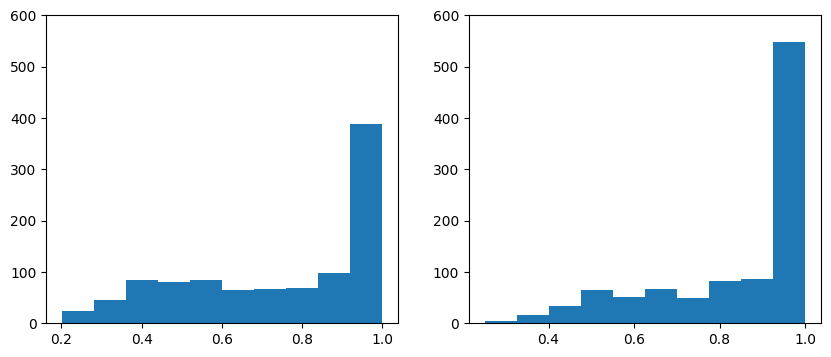

In [18]:
vl_confs_overfit = vl_probs_overfit.max(axis=1)

f, ax = plt.subplots(ncols=2, figsize=(10, 4) )
ax[0].hist(vl_confs_simple), ax[0].set_ylim([0, ylim]);
ax[1].hist(vl_confs_overfit), ax[1].set_ylim([0, ylim]);

The model is starting to become more confident, but it's also showing signs of overfitting. Without a noticeable increase in AUC, we see higher confidence values. How can we measure this miscalibration?

# Expected Calibration Error
Recall its definition as a weighted sum of the gap between confidence and accuracy over binned samples:

$${\large \mathrm{conf-ECE}\,=\,\sum_{i=1}^M \frac{1}{|B_i|} |\mathrm{conf}(B_i) - \mathrm{acc}(B_i)|}$$

In [19]:
def expected_calibration_error(y_true, y_prob, num_bins=15):
    """ Computes ECE
    Adapted from https://github.com/hollance/reliability-diagrams
    Arguments:
        y_true: the true labels for the test examples, shape=(n_classes, )
        y_prob: the probabilities for the test examples, shape = (n_samples, n_classes)
        num_bins: number of bins
    """
    y_pred = y_prob.argmax(axis=1)
    y_conf = y_prob.max(axis=1)
    
    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    
    indices         = np.digitize(y_conf, bins, right=True)
    bin_accuracies  = np.zeros(num_bins)
    bin_confidences = np.zeros(num_bins)
    bin_counts      = np.zeros(num_bins)
    
    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b]  = np.mean(y_true[selected] == y_pred[selected])
            bin_confidences[b] = np.mean(y_conf[selected])
            bin_counts[b] = len(selected)

    gaps = np.abs(bin_confidences - bin_accuracies)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    
    return ece

In [20]:
ece_simple  = expected_calibration_error(vl_labels, vl_probs_simple)
ece_overfit = expected_calibration_error(vl_labels, vl_probs_overfit)
print('ECE-simple = {:.4f}, ECE-overfit = {:.4f}'.format(ece_simple, ece_overfit))

ECE-simple = 0.0452, ECE-overfit = 0.1119


As expected, ECE captures the overconfidence of `overfit_model`.

## Visualization
Because ECE does not allow us to understand where miscalibration comes from, we can plot a reliability diagram.

In [21]:
def plot_reliability_diagram(y_true, y_prob, num_bins=15, ax = None):
    """ Computes ECE & Draws a reliability diagram
    Adapted from https://github.com/hollance/reliability-diagrams
    Arguments:
        y_true: the true labels for the test examples, shape=(n_classes, )
        y_prob: the probabilities for the test examples, shape = (n_samples, n_classes)
        num_bins: number of bins
    """
    y_pred = y_prob.argmax(axis=1)
    y_conf = y_prob.max(axis=1)
    
    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    
    indices         = np.digitize(y_conf, bins, right=True)
    bin_accuracies  = np.zeros(num_bins)
    bin_confidences = np.zeros(num_bins)
    bin_counts      = np.zeros(num_bins)
    
    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b]  = np.mean(y_true[selected] == y_pred[selected])
            bin_confidences[b] = np.mean(y_conf[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    
    nll = log_loss(y_true, y_prob)
    
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.75
    min_count = np.min(bin_counts)
    max_count = np.max(bin_counts)
    normalized_counts = (bin_counts - min_count) / (max_count - min_count)

    colors = np.zeros((len(bin_counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 85 / 255.
    colors[:, 2] = 0 / 255.
    colors[:, 3] = alphas
    
    if ax is None: f, ax = plt.subplots(figsize=(6,6))
    
    gap_plt = ax.bar(positions, np.abs(bin_accuracies - bin_confidences), 
                     bottom=np.minimum(bin_accuracies, bin_confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=bin_accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)
    if ece > 0.10: # super over confident, cluttered right-bottom corner; why 0.10? Magic, my friend
        x2, y2 = 0.05, 0.95
        x1, y1 = 0.05, 0.85
        lloc = 'lower right'
        ha, va = 'left', 'top'
    else: 
        x1, y1 = 0.95, 0.05
        x2, y2 = 0.95, 0.15
        ha, va = 'right', 'bottom'
        lloc = 'upper left'
    
    ax.text(x1, y1, "NLL={:.4f}".format(nll), color="black", ha=ha, va=va,
            fontdict={'color': 'darkred', 'weight': 'bold', 'size': 18},
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.25'))
    
    ax.text(x2, y2, "ECE={:.4f}".format(ece), color="black", ha=ha, va=va,
            fontdict={'color': 'darkred', 'weight': 'bold', 'size': 18},
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.25'))
        
    ax.set_title("Reliability Diagram", fontsize=16)
    ax.set_xlabel("Confidence", fontsize=16)
    ax.set_ylabel("Expected Accuracy", fontsize=16)
    ax.grid(True, linestyle = '--')
    ax.legend(handles=[acc_plt, gap_plt], loc=lloc)

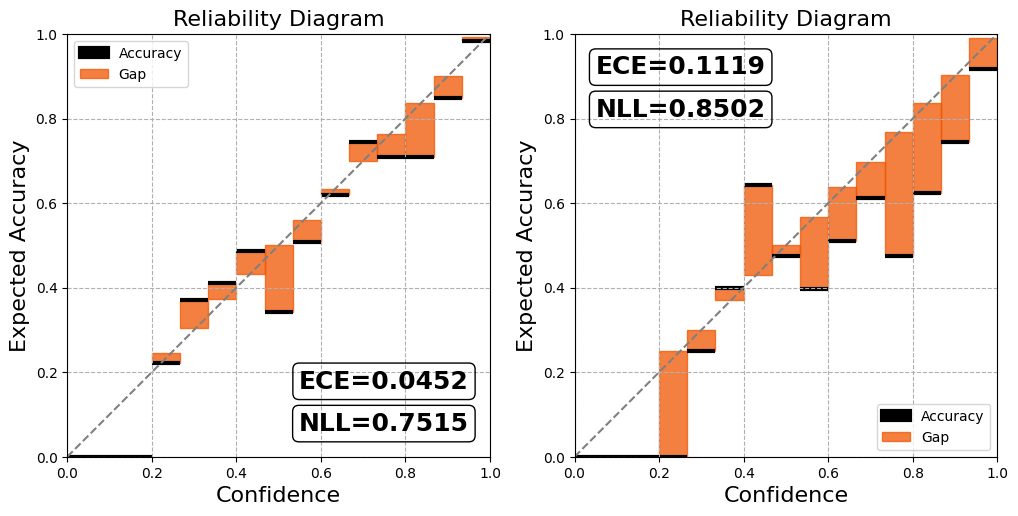

In [22]:
f, ax = plt.subplots(ncols=2, figsize=(12,12))
plot_reliability_diagram(vl_labels, vl_probs_simple, ax=ax[0])
plot_reliability_diagram(vl_labels, vl_probs_overfit, ax=ax[1])

We can certainly see overconfidence from the overfitted model.

# Temperature Scaling
This is a very simple technique to improve calibration without modifying model predictions: probability distributions change, but the predicted category remains the same. 

Temperature Scaling works by optimizing (on a validation set) a single scalar parameter, which is used to temper the predictions of the network in the pre-softmax logit space: 

$${\large \mathbf{\mathbf{\mathcal{p}_{j}}=\,\frac{e^{z_{j\,}}}{\sum_{k=1}^{N}e^{z_{k\,}}}\,\,\longmapsto}\,\,\mathcal{p}_{j}=\,\frac{\mathbf{e^{\left(z_{j}/T\right)}}}{\mathbf{\sum_{k=1}^{N}e^{\left(z_{k}/T\right)}}}}$$

When temperature is positive, scaling reduces logits magnitude, and after applying the softmax overconfidence can be reduced. If temperature is negative, the opposite happens. Let's see it in action.

In [23]:
# We want to optimize for temperature, so we freeze all other parameters:
for parameter in simple_model.parameters():
    parameter.requires_grad = False

for parameter in overfit_model.parameters():
    parameter.requires_grad = False

In [33]:
# First: collect all the logits and labels on the validation set
logits_simple_list, logits_overfit_list = [], []
labels_list = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits_simple = simple_model(inputs)
        logits_overfit = overfit_model(inputs)
        
        logits_simple_list.append(logits_simple)
        logits_overfit_list.append(logits_overfit)
        labels_list.append(labels)
    logits_simple  = torch.cat(logits_simple_list)
    logits_overfit = torch.cat(logits_overfit_list)
    labels = torch.cat(labels_list).squeeze()

logits_simple.shape, logits_overfit.shape, labels.shape

(torch.Size([1003, 7]), torch.Size([1003, 7]), torch.Size([1003]))

In [34]:
pre_temperature_ece_simple  = expected_calibration_error(labels, logits_simple.cpu().softmax(1).numpy())
pre_temperature_ece_overfit = expected_calibration_error(labels, logits_overfit.cpu().softmax(1).numpy())
print('ECE pre-Temp Scaling simple/overfit = {:.4f}/{:.4f}'.format(pre_temperature_ece_simple, 
                                                                   pre_temperature_ece_overfit))

ECE pre-Temp Scaling simple/overfit = 0.7531/0.8499


We find a temperature value that minimizes NLL, as ECE is non-differentiable:

In [37]:
def find_optimal_temp(logits, labels):
    temperature = torch.nn.Parameter(1.*torch.ones(1), requires_grad=True)
    optimizer = torch.optim.SGD([temperature], lr=1e-2)
    criterion = torch.nn.CrossEntropyLoss()
    
    best_nll = 1000
    best_temperature = 1.
    for iteration in tqdm(range(2000)):
        scaled_logits = logits/temperature.to(device)
        nll = criterion(scaled_logits, labels)
        if nll < best_nll:
            best_temp = temperature.item()
            best_nll = nll
        if iteration%200==0: print('Temperature = {:.6f}, NLL = {:.6f}'.format(temperature.item(), nll.item()))
        nll.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return best_temp

In [38]:
print('Temperature Scaling for Simple Model')
best_temp_simple  = find_optimal_temp(logits_simple, labels)
print('\nTemperature Scaling for Overfit Model')
best_temp_overfit = find_optimal_temp(logits_overfit, labels)

Temperature Scaling for Simple Model


  8%|████████████▉                                                                                                                                                     | 160/2000 [00:00<00:01, 1599.27it/s]

Temperature = 1.000000, NLL = 0.751508
Temperature = 1.150189, NLL = 0.739276
Temperature = 1.213034, NLL = 0.737215


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1683/2000 [00:00<00:00, 4714.51it/s]

Temperature = 1.244457, NLL = 0.736705
Temperature = 1.261275, NLL = 0.736559
Temperature = 1.270573, NLL = 0.736515
Temperature = 1.275800, NLL = 0.736501
Temperature = 1.278766, NLL = 0.736497
Temperature = 1.280457, NLL = 0.736495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4321.27it/s]


Temperature = 1.281425, NLL = 0.736495

Temperature Scaling for Overfit Model


 19%|███████████████████████████████▍                                                                                                                                  | 388/2000 [00:00<00:00, 3879.26it/s]

Temperature = 1.000000, NLL = 0.858371
Temperature = 1.459674, NLL = 0.737568
Temperature = 1.643991, NLL = 0.720043
Temperature = 1.751124, NLL = 0.714208


 45%|█████████████████████████████████████████████████████████████████████████▎                                                                                        | 905/2000 [00:00<00:00, 4636.99it/s]

Temperature = 1.821157, NLL = 0.711727


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1480/2000 [00:00<00:00, 5144.04it/s]

Temperature = 1.869721, NLL = 0.710537
Temperature = 1.904597, NLL = 0.709924
Temperature = 1.930218, NLL = 0.709594
Temperature = 1.949332, NLL = 0.709410
Temperature = 1.963751, NLL = 0.709306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4354.09it/s]


Note how the temperature found for the overfit model is considerably higher, as it is overconfident. Observe also how as the temperature values change the NLL decreases. In the orginal implementation there is a slightly different optimization procedure that we show below:

In [39]:
def find_optimal_temp_alternative(logits, labels):
    # Alternative optimization from original paper, uses 2nd order optimizer (with closure), gives similar results
    # https://github.com/gpleiss/temperature_scaling
    temperature = torch.nn.Parameter(1.*torch.ones(1), requires_grad=True)
    optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=1000)
    criterion = torch.nn.CrossEntropyLoss()
    def eval():
        optimizer.zero_grad()
        scaled_logits = logits/temperature.to(device)
        loss = criterion(scaled_logits, labels)
        loss.backward()
        return loss
    optimizer.step(eval)
    
    return temperature

find_optimal_temp_alternative(logits_overfit, labels)

Parameter containing:
tensor([2.0005], requires_grad=True)

Now the question is, have we improved ECE by using Temperature Scaling? In order to answer this, we need to use the test set because the optimal temperature has been learned on the validation set, so it would be overoptimistic to measure performance there. The following function generates predictions on the test set with an optional temperature scaling parameter:

In [40]:
def run_test_epoch(loader, model, temperature=1):
    device='cuda' if next(model.parameters()).is_cuda else 'cpu'
    model.eval()
    probs_all, labels_all = [], []
    criterion = torch.nn.CrossEntropyLoss(reduction='none') 
    
    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        logits = model(inputs)/temperature
        
        probs = logits.softmax(dim=1).cpu().numpy()        
        labels = labels.cpu().numpy()
        
        probs_all.extend(probs)
        labels_all.extend(labels)
    
    return np.stack(probs_all), np.stack(labels_all)

We use it to compute ECE on the test set:

In [41]:
test_probs_simple, test_labels = run_test_epoch(test_loader, simple_model, temperature=1.)
pre_temperature_ece_simple = expected_calibration_error(test_labels, test_probs_simple)

test_probs_overfit, test_labels = run_test_epoch(test_loader, overfit_model, temperature=1.)
pre_temperature_ece_overfit = expected_calibration_error(test_labels, test_probs_overfit)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.07it/s]


In [42]:
test_probs_simple_ts, test_labels = run_test_epoch(test_loader, simple_model, temperature=best_temp_simple)
post_temperature_ece_simple = expected_calibration_error(test_labels, test_probs_simple_ts)

test_probs_overfit_ts, test_labels = run_test_epoch(test_loader, overfit_model, temperature=best_temp_overfit)
post_temperature_ece_overfit = expected_calibration_error(test_labels, test_probs_overfit_ts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 26.94it/s]


In [43]:
print('Simple Model:  Temperature = {:.4f}, ECE = {:.4f} --> {:.4f}'.format(best_temp_simple, 
                                                                            pre_temperature_ece_simple, 
                                                                            post_temperature_ece_simple))

print('Overfit Model: Temperature = {:.4f}, ECE = {:.4f} --> {:.4f}'.format(best_temp_overfit, 
                                                                            pre_temperature_ece_overfit, 
                                                                            post_temperature_ece_overfit))

Simple Model:  Temperature = 1.2817, ECE = 0.0488 --> 0.0265
Overfit Model: Temperature = 1.9746, ECE = 0.0968 --> 0.0344


We can actually plot the reliability diagrams:

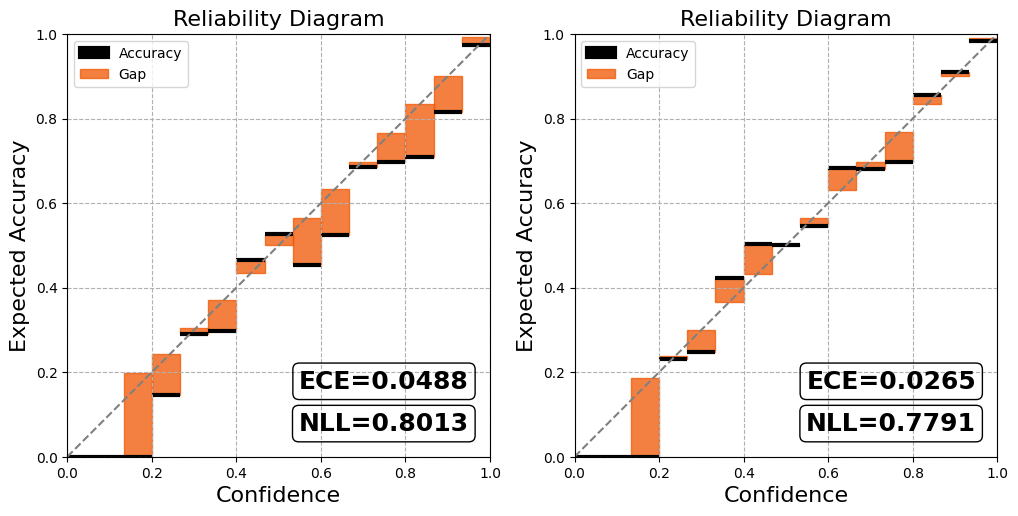

In [44]:
f, ax = plt.subplots(ncols=2, figsize=(12,12))
plot_reliability_diagram(test_labels, test_probs_simple, ax=ax[0])
plot_reliability_diagram(test_labels, test_probs_simple_ts, ax=ax[1])

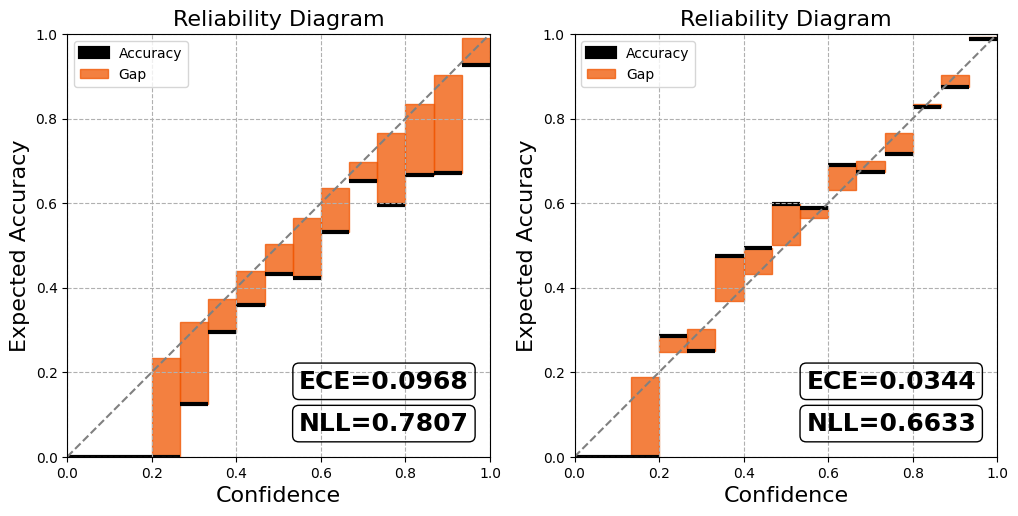

In [45]:
f, ax = plt.subplots(ncols=2, figsize=(12,12))
plot_reliability_diagram(test_labels, test_probs_overfit, ax=ax[0])
plot_reliability_diagram(test_labels, test_probs_overfit_ts, ax=ax[1])

# Label Smoothing

As mentioned in the slides, regularization mechanisms like Label Smoothing can be effective against overconfidence, at the risk of overfitting. We train now the same amount of epochs as in `overfit_model`, but with a (rather large) label smoothing value:

In [46]:
ls_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = ls_model.fc.in_features
ls_model.fc = torch.nn.Linear(num_ftrs, out_features=N_CLASSES)
ls_model.to(device);

optimizer = torch.optim.SGD(ls_model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.5) # a very large value

In [47]:
for epoch in tqdm(range(n_epochs_overfit)):
    _, _, _ = run_one_epoch(train_loader, ls_model, criterion, optimizer)
    with torch.inference_mode():
        tr_preds, tr_probs, tr_labels = run_one_epoch(train_loader, ls_model, criterion)
        vl_preds, vl_probs_ls, vl_labels = run_one_epoch(val_loader, ls_model, criterion)

        tr_auc = roc_auc_score(tr_labels, tr_probs, multi_class='ovr')
        vl_auc = roc_auc_score(vl_labels, vl_probs_ls, multi_class='ovr')
        print('Epoch {}, TR/VL AUC={:.2f}/{:.2f}'.format(epoch+1, 100*tr_auc, 100*vl_auc))       

  5%|████████▍                                                                                                                                                               | 1/20 [00:03<01:13,  3.85s/it]

Epoch 1, TR/VL AUC=74.29/67.07


 10%|████████████████▊                                                                                                                                                       | 2/20 [00:08<01:14,  4.14s/it]

Epoch 2, TR/VL AUC=81.16/76.83


 15%|█████████████████████████▏                                                                                                                                              | 3/20 [00:12<01:08,  4.04s/it]

Epoch 3, TR/VL AUC=82.04/77.84


 20%|█████████████████████████████████▌                                                                                                                                      | 4/20 [00:15<01:03,  3.97s/it]

Epoch 4, TR/VL AUC=82.84/80.93


 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [00:19<00:58,  3.93s/it]

Epoch 5, TR/VL AUC=85.46/85.50


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [00:23<00:54,  3.91s/it]

Epoch 6, TR/VL AUC=88.25/85.10


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [00:27<00:50,  3.88s/it]

Epoch 7, TR/VL AUC=87.87/86.55


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [00:31<00:46,  3.87s/it]

Epoch 8, TR/VL AUC=89.62/89.90


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [00:35<00:42,  3.91s/it]

Epoch 9, TR/VL AUC=89.65/89.41


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [00:39<00:39,  3.95s/it]

Epoch 10, TR/VL AUC=90.66/90.30


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [00:43<00:35,  3.98s/it]

Epoch 11, TR/VL AUC=91.53/91.18


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [00:47<00:31,  3.94s/it]

Epoch 12, TR/VL AUC=91.75/90.61


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [00:51<00:27,  3.93s/it]

Epoch 13, TR/VL AUC=89.42/88.52


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [00:55<00:23,  3.93s/it]

Epoch 14, TR/VL AUC=90.97/91.89


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [00:59<00:19,  3.95s/it]

Epoch 15, TR/VL AUC=92.92/92.45


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [01:03<00:15,  3.95s/it]

Epoch 16, TR/VL AUC=91.74/90.14


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 17/20 [01:07<00:11,  3.98s/it]

Epoch 17, TR/VL AUC=91.43/91.10


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 18/20 [01:11<00:08,  4.00s/it]

Epoch 18, TR/VL AUC=92.68/92.40


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 19/20 [01:15<00:03,  4.00s/it]

Epoch 19, TR/VL AUC=93.04/93.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.96s/it]

Epoch 20, TR/VL AUC=91.29/91.09


Not bad! Let us visually inspect confidence values for each of our three models:

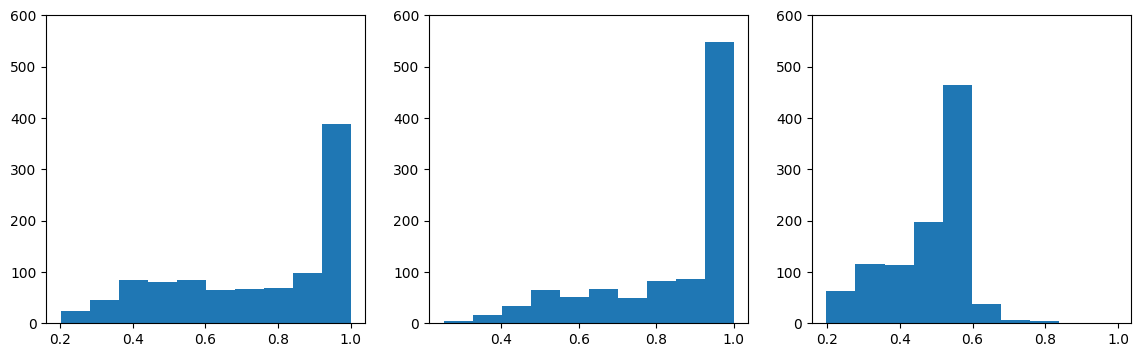

In [48]:
vl_confs_ls = vl_probs_ls.max(axis=1)

f, ax = plt.subplots(ncols=3, figsize=(14, 4))
ax[0].hist(vl_confs_simple), ax[0].set_ylim([0, ylim]);
ax[1].hist(vl_confs_overfit), ax[1].set_ylim([0, ylim]);
ax[2].hist(vl_confs_ls), ax[2].set_ylim([0, ylim]);

Label smoothing succeeds at combatting overconfidence, but we might be having a problem of underconfidence now! Let us inspect calibration errors:

In [49]:
ece_simple  = expected_calibration_error(vl_labels, vl_probs_simple)
ece_overfit = expected_calibration_error(vl_labels, vl_probs_overfit)
ece_ls      = expected_calibration_error(vl_labels, vl_probs_ls)
print('ECE-simple = {:.4f}, ECE-overfit = {:.4f}, ECE-LS = {:.4f}'.format(ece_simple, ece_overfit, ece_ls))

ECE-simple = 0.0452, ECE-overfit = 0.1119, ECE-LS = 0.2643


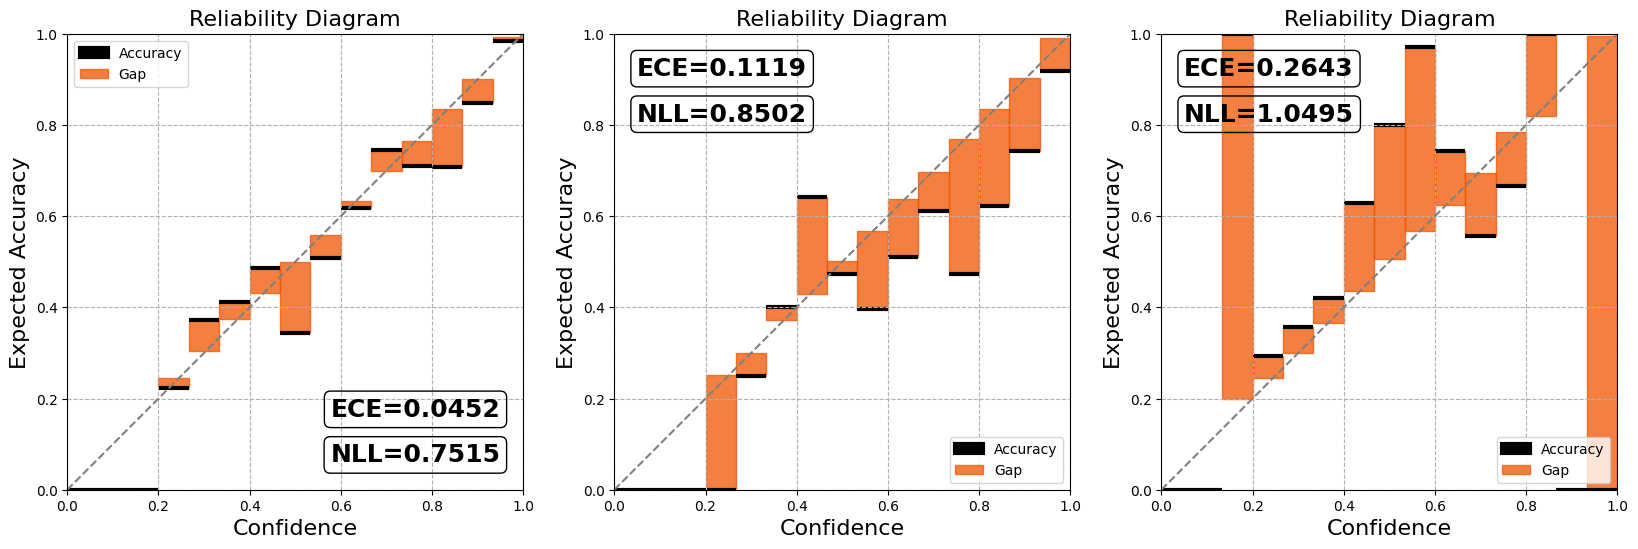

In [50]:
f, ax = plt.subplots(ncols=3, figsize=(20,20))
plot_reliability_diagram(vl_labels, vl_probs_simple, ax=ax[0])
plot_reliability_diagram(vl_labels, vl_probs_overfit, ax=ax[1])
plot_reliability_diagram(vl_labels, vl_probs_ls, ax=ax[2])

We can also apply temperature scaling to the label smoothing model:

In [51]:
# We want to optimize for temperature, so we freeze all other parameters:
for parameter in ls_model.parameters():
    parameter.requires_grad = False

In [52]:
# First: collect all the logits and labels on the validation set
logits_ls_list = []
labels_list = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits_ls = ls_model(inputs)
        
        logits_ls_list.append(logits_ls)
        labels_list.append(labels)
    logits_ls  = torch.cat(logits_ls_list)
    labels = torch.cat(labels_list).squeeze()

In [53]:
best_temp_ls = find_optimal_temp(logits_ls, labels)

 49%|████████████████████████████████████████████████████████████████████████████████                                                                                  | 988/2000 [00:00<00:00, 5018.15it/s]

Temperature = 1.000000, NLL = 1.049544
Temperature = 0.550696, NLL = 0.881390
Temperature = 0.549413, NLL = 0.881387
Temperature = 0.549413, NLL = 0.881387
Temperature = 0.549413, NLL = 0.881387


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1490/2000 [00:00<00:00, 4958.60it/s]

Temperature = 0.549413, NLL = 0.881387
Temperature = 0.549413, NLL = 0.881387
Temperature = 0.549413, NLL = 0.881387
Temperature = 0.549413, NLL = 0.881387
Temperature = 0.549413, NLL = 0.881387


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4719.55it/s]


Because this model was underconfident, temperature scaling now finds a value below 1.

In [54]:
test_probs_ls, test_labels = run_test_epoch(test_loader, ls_model, temperature=1.)
pre_temperature_ece_ls = expected_calibration_error(test_labels, test_probs_ls)

test_probs_ls_ts, test_labels = run_test_epoch(test_loader, ls_model, temperature=best_temp_ls)
post_temperature_ece_ls = expected_calibration_error(test_labels, test_probs_ls_ts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.59it/s]


Let us see how each model changes ECE when applying Temperature Scaling:

In [55]:
print('Simple Model:  Temperature = {:.4f}, ECE = {:.4f} --> {:.4f}'.format(best_temp_simple, 
                                                                            pre_temperature_ece_simple, 
                                                                            post_temperature_ece_simple))

print('Overfit Model: Temperature = {:.4f}, ECE = {:.4f} --> {:.4f}'.format(best_temp_overfit, 
                                                                            pre_temperature_ece_overfit, 
                                                                            post_temperature_ece_overfit))

print('LS Model:      Temperature = {:.4f}, ECE = {:.4f} --> {:.4f}'.format(best_temp_ls, 
                                                                       pre_temperature_ece_ls, 
                                                                       post_temperature_ece_ls))

Simple Model:  Temperature = 1.2817, ECE = 0.0488 --> 0.0265
Overfit Model: Temperature = 1.9746, ECE = 0.0968 --> 0.0344
LS Model:      Temperature = 0.5495, ECE = 0.2416 --> 0.0892


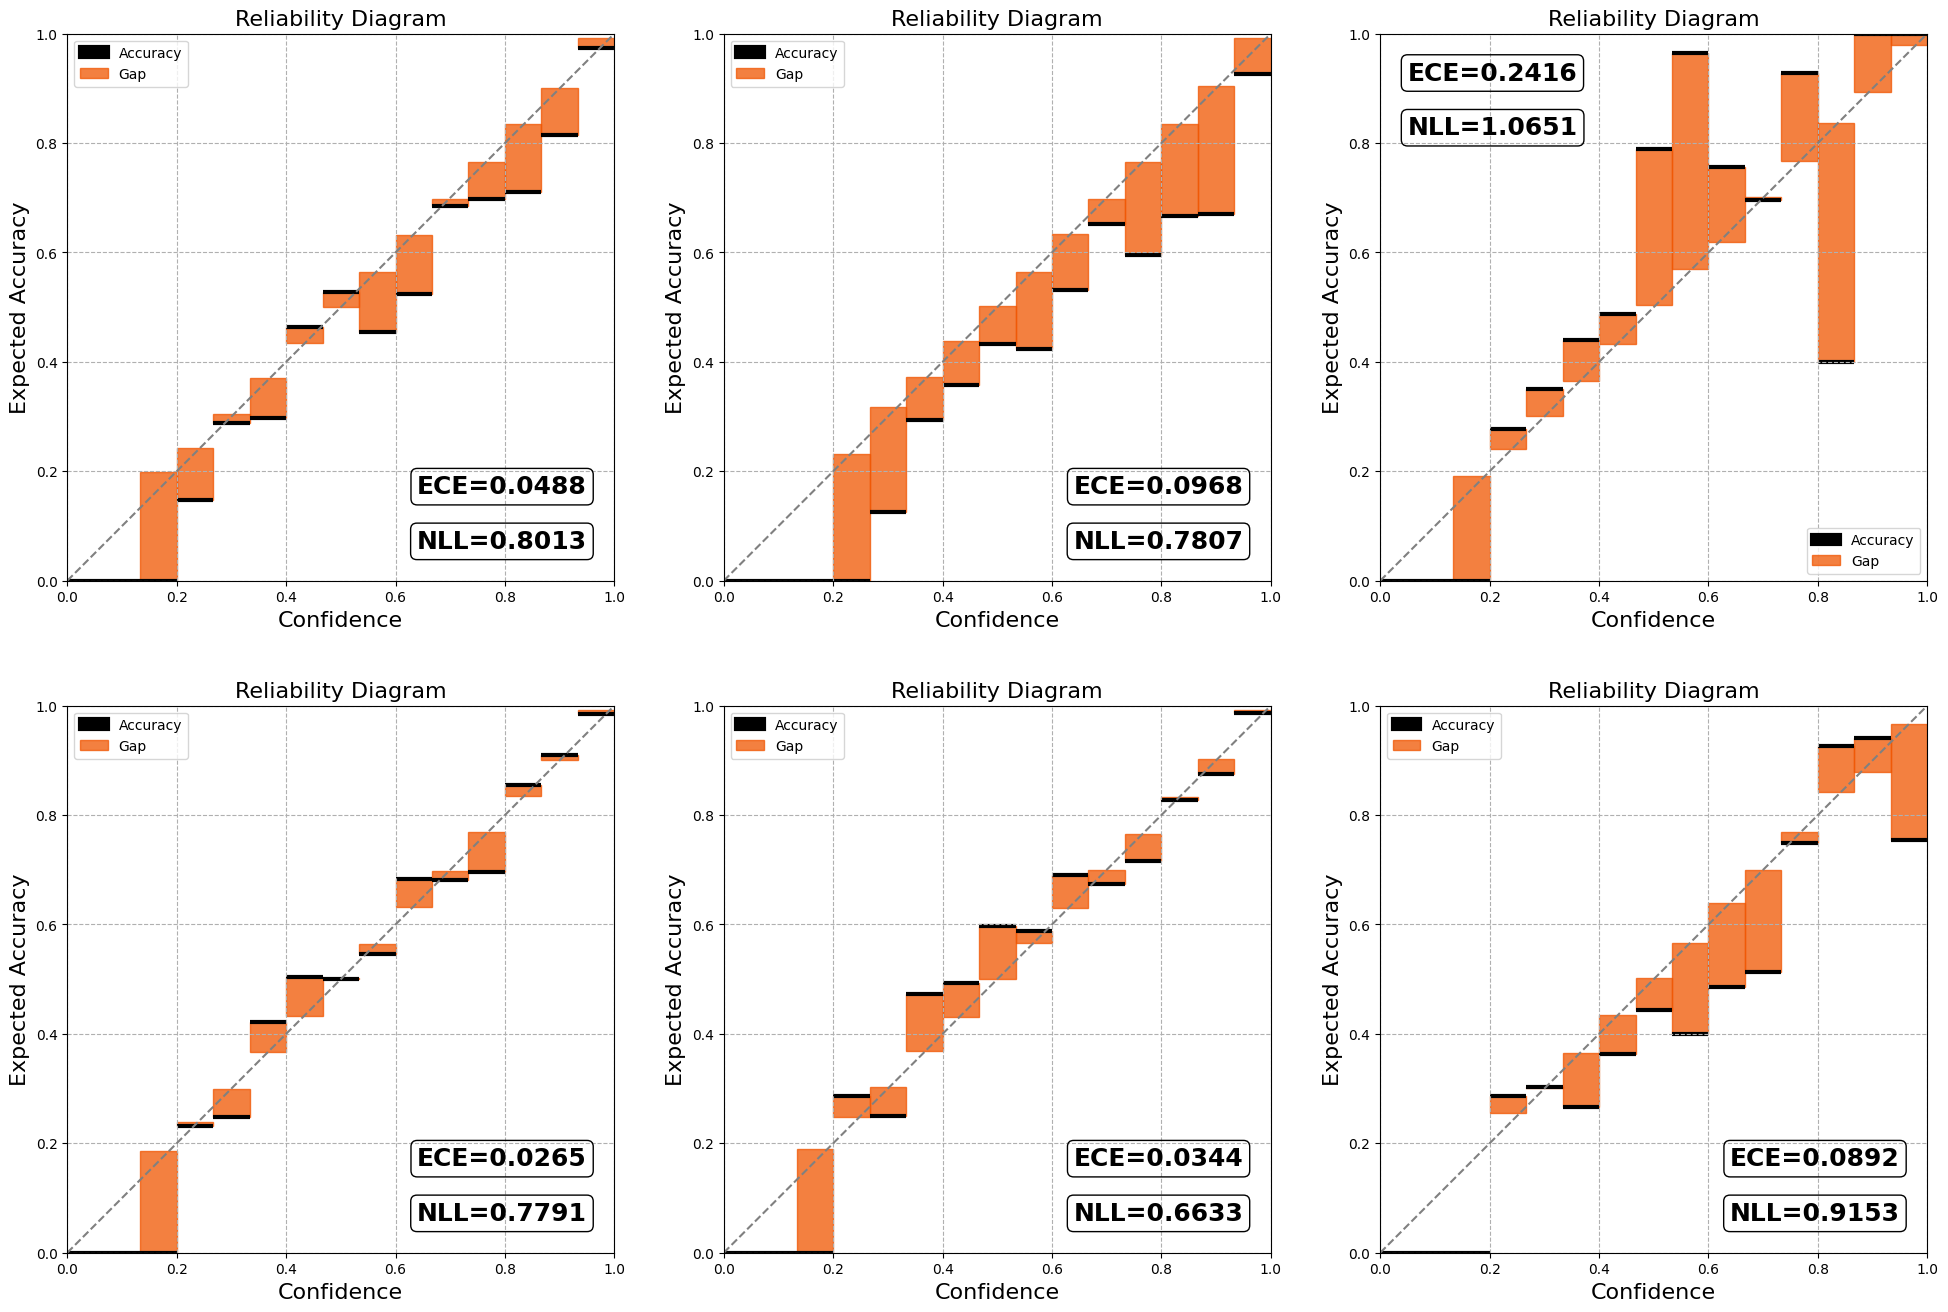

In [56]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(24,16))
plot_reliability_diagram(test_labels, test_probs_simple, ax=ax[0,0])
plot_reliability_diagram(test_labels, test_probs_overfit, ax=ax[0,1])
plot_reliability_diagram(test_labels, test_probs_ls, ax=ax[0,2])

plot_reliability_diagram(test_labels, test_probs_simple_ts, ax=ax[1,0])
plot_reliability_diagram(test_labels, test_probs_overfit_ts, ax=ax[1,1])
plot_reliability_diagram(test_labels, test_probs_ls_ts, ax=ax[1,2])

Note that the temperature-scaled overfit model is slighlty worse calibrated than the temperature-scaled simple model, but has much better NLL. This is because it is more discriminative (better ACC/AUC).